# DS207: Spotify Genre Classification Project
#### SEC2 - Nicholas Lin, Yoni Nackash, Rex Gao

## Introduction & Context

asdf

## Data Preprocessing

In [1]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', None)

In [2]:
#loading the data
raw_df = pd.read_csv('spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
df = raw_df.copy()
print('Shape of dataframe:', df.shape)

# Remove null row
print('Step 1: Removing rows with NA')
df.dropna(inplace=True)

# Map explicit field to binary
df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
print("Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks")
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
print('Step 3: Drop tracks with more than one assigned genre')
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)]

# With duplicate tracks and tracks with multiple genres removed, drop unnecessary columns for classification
print("Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'")
df = df.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

print('Shape of dataframe:', df.shape)

Shape of dataframe: (114000, 21)
Step 1: Removing rows with NA
Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks
Step 3: Drop tracks with more than one assigned genre
Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'
Shape of dataframe: (73441, 15)


## EDA

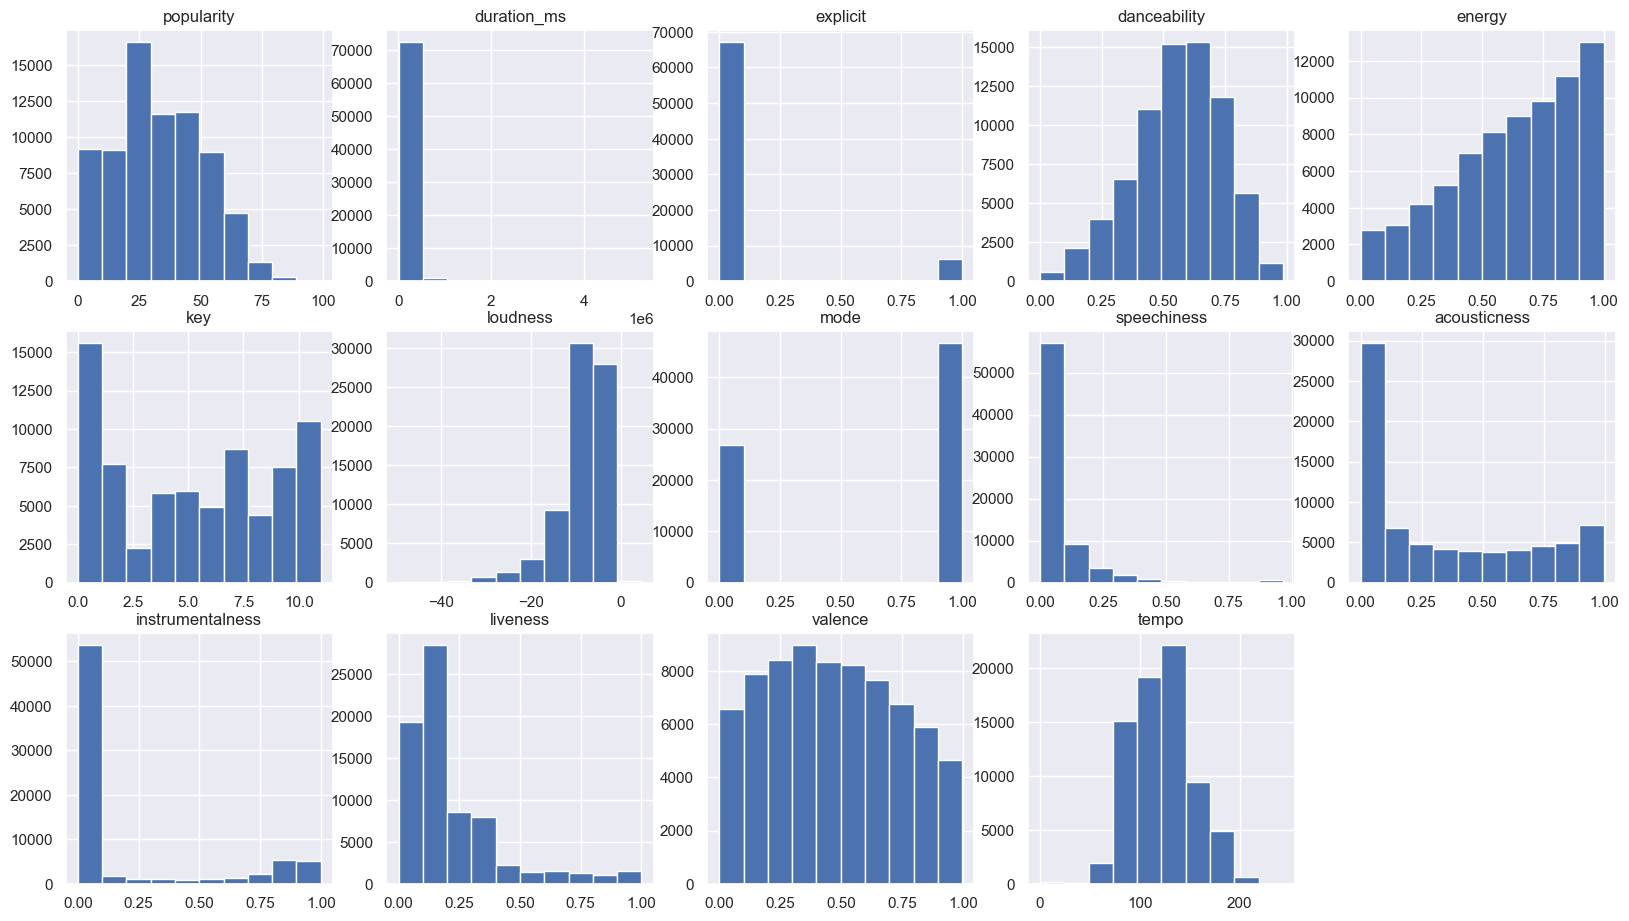

In [4]:
#Plotting feature histograms
features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(20, 15))
for i in range(len(features)):
  plt.subplot(4, 5, i+1)
  plt.hist(np.array(df[features[i]]))
  plt.title(features[i])
plt.show()

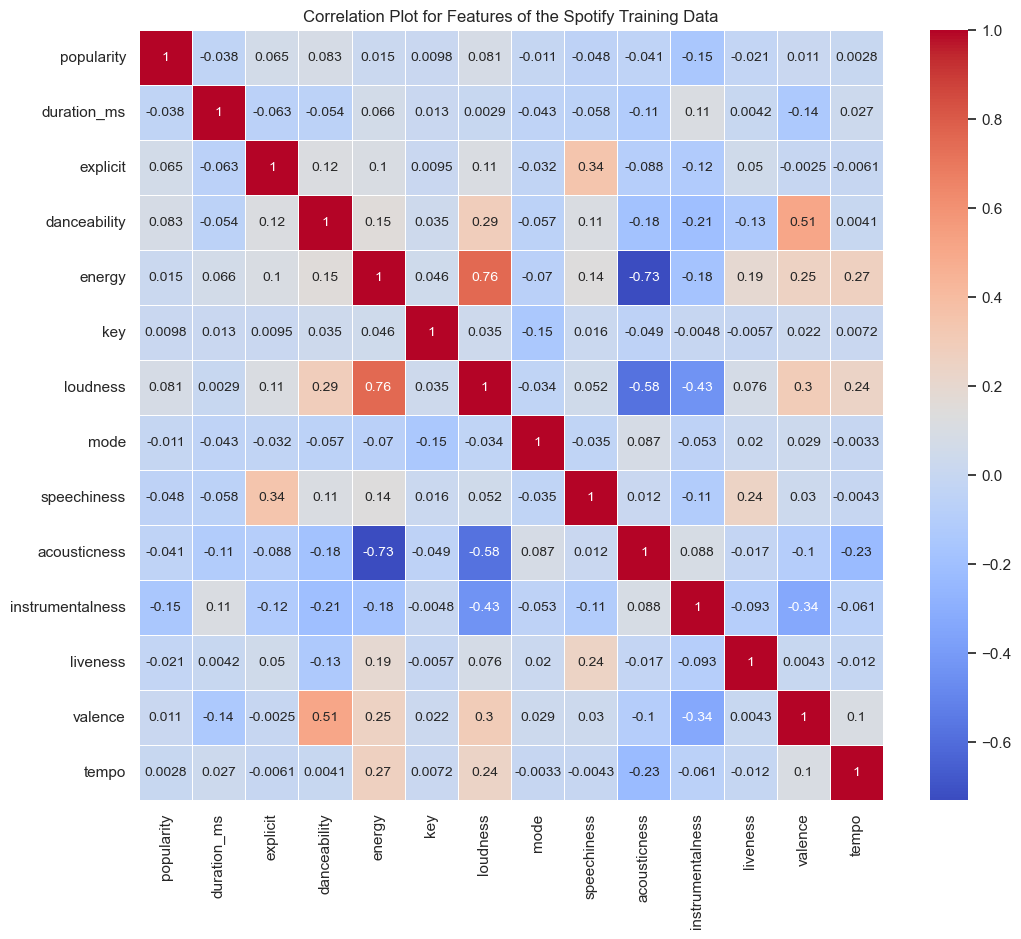

In [5]:
#Plotting correlation plot of the features
plt.figure(figsize=(12,10))
corr = df[features].corr()
sns.heatmap(corr, annot = True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Plot for Features of the Spotify Training Data')

plt.show()

## Feature Engineering

In [6]:
# One hot encode key field
df = pd.get_dummies(df, columns=['key'], dtype=int)
df = df.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

df['popularity'] = df['popularity'].astype(int)
df['duration_ms'] = df['duration_ms'].astype(int)
df['mode'] = df['mode'].astype(int)

print(df.shape)
df.head()

(73441, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.143,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.167,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.669,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.301,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
# Bin the popularity field
df['popularity_bin'] = pd.qcut(df.popularity,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['popularity_bin'], dtype=int)

# Remove tracks that are less than 60 seconds
df = df[df['duration_ms'] > 60000]

# Keep tracks with duration within 98th percentile
df = df[df['duration_ms'] < df['duration_ms'].quantile(.98)]

# Bin the duration_ms field
df['duration_bin'] = pd.qcut(df.duration_ms,q=4,labels=[1,2,3,4])
df = pd.get_dummies(df, columns=['duration_bin'], dtype=int)
df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,popularity_bin_1,popularity_bin_2,popularity_bin_3,popularity_bin_4,popularity_bin_5,duration_bin_1,duration_bin_2,duration_bin_3,duration_bin_4
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.1430,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.1670,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.6690,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.3010,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.640,0.928000,0.0863,0.0339,125.995,world-music,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.994,0.976000,0.1050,0.0350,85.239,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.867,0.000000,0.0839,0.7430,132.378,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.381,0.000000,0.2700,0.4130,135.960,world-music,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


## Feature Selection

In [8]:
# Set features to use in model
features = [
    # 'popularity',
    # 'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'C',
    # 'C#',
    # 'D',
    # 'D#',
    # 'E',
    # 'F',
    # 'F#',
    # 'G',
    # 'G#',
    # 'A',
    # 'A#',
    # 'B',
    'popularity_bin_1',
    'popularity_bin_2',
    'popularity_bin_3',
    'popularity_bin_4',
    'popularity_bin_5',
    'duration_bin_1',
    'duration_bin_2',
    'duration_bin_3',
    'duration_bin_4'
]

# Load tracks and genre labels
tracks = df[features]
labels = df['track_genre']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of tracks  (71256, 19)
Shape of labels  (71256,)


## Data Shuffling

In [9]:
# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

## Data Normalizing - Does normalizing need to be done after split for proper train/test normalization?

In [10]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

## Data Splitting

In [11]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (57004, 19)
Shape of train labels  (57004,)
Shape of test images  (14252, 19)
Shape of test labels  (14252,)
Check for any null values: 0


## Baseline Model

In [12]:
#show class distribution
unique, counts = np.unique(Y_train, return_counts = True)
class_counts = dict(zip(unique, counts))
class_counts

{0: 655,
 1: 727,
 2: 119,
 3: 123,
 4: 547,
 5: 523,
 6: 640,
 7: 760,
 8: 304,
 9: 212,
 10: 705,
 11: 438,
 12: 708,
 13: 669,
 14: 692,
 15: 466,
 16: 434,
 17: 774,
 18: 726,
 19: 704,
 20: 353,
 21: 531,
 22: 517,
 23: 402,
 24: 642,
 25: 495,
 26: 654,
 27: 740,
 28: 158,
 29: 227,
 30: 99,
 31: 269,
 32: 538,
 33: 436,
 34: 328,
 35: 710,
 36: 664,
 37: 398,
 38: 612,
 39: 483,
 40: 483,
 41: 610,
 42: 647,
 43: 402,
 44: 597,
 45: 692,
 46: 616,
 47: 302,
 48: 540,
 49: 737,
 50: 774,
 51: 427,
 52: 758,
 53: 159,
 54: 751,
 55: 408,
 56: 101,
 57: 206,
 58: 643,
 59: 666,
 60: 572,
 61: 724,
 62: 275,
 63: 294,
 64: 351,
 65: 622,
 66: 709,
 67: 190,
 68: 111,
 69: 797,
 70: 711,
 71: 117,
 72: 570,
 73: 459,
 74: 354,
 75: 636,
 76: 659,
 77: 521,
 78: 645,
 79: 575,
 80: 321,
 81: 519,
 82: 670,
 83: 481,
 84: 403,
 85: 162,
 86: 185,
 87: 319,
 88: 69,
 89: 57,
 90: 221,
 91: 519,
 92: 510,
 93: 728,
 94: 448,
 95: 766,
 96: 522,
 97: 661,
 98: 678,
 99: 566,
 100: 733,
 1

In [13]:
#stratified baseline implementation
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, Y_train)
Y_pred = dummy_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print(f'Baseline Classifier Accuracy: {accuracy}')
print(f'Classification Report: {report}')

Baseline Classifier Accuracy: 0.010735335391523996
Classification Report:               precision    recall  f1-score   support

           0       0.01      0.01      0.01       164
           1       0.00      0.00      0.00       185
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        35
           4       0.02      0.02      0.02       146
           5       0.00      0.00      0.00       129
           6       0.01      0.01      0.01       143
           7       0.02      0.02      0.02       195
           8       0.01      0.01      0.01        79
           9       0.00      0.00      0.00        57
          10       0.01      0.01      0.01       175
          11       0.00      0.00      0.00       115
          12       0.02      0.02      0.02       165
          13       0.01      0.01      0.01       160
          14       0.03      0.02      0.02       195
          15       0.01      0.01      0.01       118
       

## KNN

## Clustering

## Research & Manual Genre Mapping

## Class Distribution Fixing
-- will be adjusted once we add in our genre mapping

In [14]:
min_count = labels.value_counts().min()
result = {}
unique_classes = np.unique(labels)
for value in unique_classes:
    indices = np.where(labels==value)[0][:min_count]
    result[value] = indices.tolist()
index_values = list(result.values())
index_values = [element for nestedlist in index_values for element in nestedlist]
tracks_scaled = tracks_scaled[index_values]
labels_encoded = labels_encoded[index_values]

<Axes: >

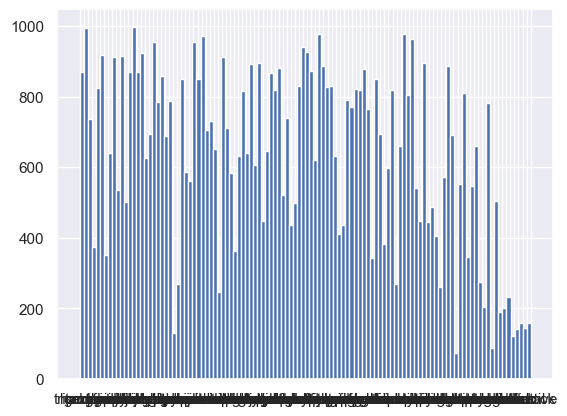

In [15]:
labels.hist(bins=labels_count)

In [16]:
#Resplit
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (6451, 19)
Shape of train labels  (6451,)
Shape of test images  (1613, 19)
Shape of test labels  (1613,)
Check for any null values: 0


## KNN Revisted

## Decision Trees

## Neural Networks

## Conclusion